# **Clinical Predictors for Chronic Kidney Disease: An Exploration using Random Forest Modelling** 

## Introduction
This project aims to explore multiple clinical markers' predictive potential for chronic kidney disease (CKD). Though the many of the markers' relation to CKD are well established, this project shows quantify the correlations, while leveraging visualisations for a more user-friendly interpretation. We will also construct a machine learning model for predicting CKD. 

Our dataset was created by [Rubini et al.](https://archive.ics.uci.edu/dataset/336/chronic+kidney+disease), over a two-month period from an unspecified hospital in India. 
* The variable of interest is CKD/no CKD
* Predictive cinical attributes are:
    * age
    * blood pressure
    * specific gravity
    * albumin
    * sugar 
    * red blood cells
    * pus cell
    * pus cell clumps
    * bacteria
    * blood glucose random
    * blood urea
    * serum creatinine
    * sodium
    * potassium
    * hemoglobin
    * packed cell volume
    * white blood cell count
    * red blood cell count
    * hypertension
    * diabetes mellitus
    * coronary artery disease
    * appetite
    * pedal edema
    * anemia
    
    (units unspecified but will be standardised anyways)

### CKD Definition
Firstly, we should note that classifying a patient as 'has CKD' or 'has no CKD' is not absolutely objective. As always, clinicians' discretion is a major consideration and diagnostic criterion differ from between countries. Though the dataset was collected in India, this project will approach CKD from the perspective of Australian healthcare. This project follows Kidney Health Australia's [CKD handbook](https://kidney.org.au/uploads/resources/CKD-Management-in-Primary-Care_handbook_2020.1.pdf) definition of CKD as:
* an estimated or measured glomerular filtration rate (GFR) less than 60mL/min/1.73m<sup>2</sup> present for over 3 months

OR

* evidence of kidney damage, as evidenced through albuminuria, haematuria, structural abnormalities or pathological abnormalities

This definition should suggest of the relevance of many features.

## Preprocessing

In [1]:
import warnings
warnings.filterwarnings("ignore") # for display cleanliness

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#### Loading dataset

In [2]:
df = pd.read_csv(
    r'C:\Users\az231\Downloads\Datasets\Chronic_Kidney_Disease\chronic_kidney_disease_full.arff', 
    skiprows=145, 
    sep=',', 
    on_bad_lines='warn', 
    header=None, 
    na_values='?',
    names = [
        'age', 
        'blood pressure', 
        'specific gravity',
        'albumin', 
        'sugar', 
        'red blood cells', 
        'pus cell', 
        'pus cell clumps', 
        'bacteria', 
        'blood glucose random', 
        'blood urea', 
        'serum creatinine', 
        'sodium', 
        'potassium', 
        'hemoglobin', 
        'packed cell volume', 
        'white blood cell count', 
        'red blood cell count', 
        'hypertension', 
        'diabetes mellitus', 
        'coronary artery disease', 
        'appetite', 
        'pedal edema', 
        'anemia', 
        'class'
    ]
)

#### Cleaning dataset

In [3]:
for col_name in df.select_dtypes(exclude='number').columns:
    df[col_name] = df[col_name].str.strip()
df.replace('?', np.nan, inplace=True)
df['packed cell volume'] = df['packed cell volume'].astype(float)
df['white blood cell count'] = df['white blood cell count'].astype(float)
df['red blood cell count'] = df['red blood cell count'].astype(float)
df = df.replace(
    {
        'notpresent':0,
        'present':1,
        'ckd':1,
        'notckd':0,
        'yes':1,
        'no':0,
        'good':1,
        'poor':0,
        'abnormal':1,
        'normal':0
    }
)
df.rename(columns={'pus cell':'pus cell_abnormal'}, inplace=True)

#### Missing values of 'ckd' and 'notckd'

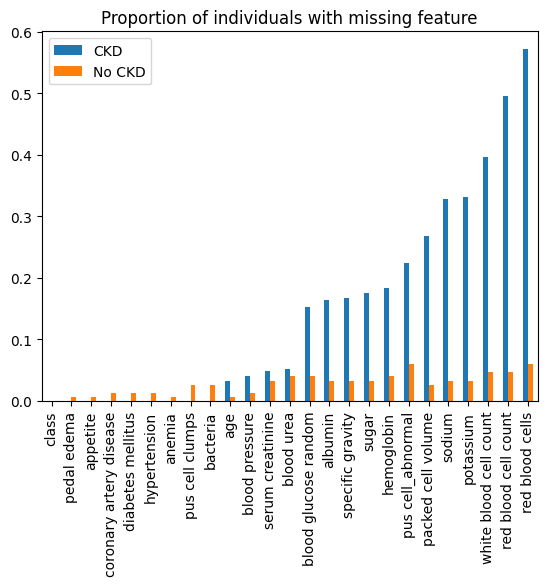

In [4]:
ckd = df[df['class']==1]
notckd = df[df['class']==0]

ckd_prop_missing = (
    ckd.isna().sum()/ckd.shape[0]
).sort_values().to_frame(name="ckd")

notckd_prop_missing = (
    notckd.isna().sum()/ notckd.shape[0]
).sort_values().to_frame(name="notckd")

missing_prop = pd.concat([ckd_prop_missing, notckd_prop_missing], axis=1)
missing_prop.plot(
    kind='bar', 
    title='Proportion of individuals with missing feature',
)

plt.legend(labels=['CKD', 'No CKD'])
plt.show()

For patients with CKD, there is a higher chance of missing values for most features. Hence, 'missing information' itself is a correlatable attribute.
* Therefore, a new column about value 'missingness' will be created for every feature.
* In the original feature columns, the missing value will be filled with an average value. 
  * If there are little unique values, use mode instead of mean.

In [5]:
for subgroup in [ckd, notckd]:
    for col_name in subgroup.columns[:-1]:
        
        # creating a 'missing' feauture for given column
        subgroup[f'{col_name}_missing'] = subgroup[col_name].isna().astype('int8')
        
        # filling missing value with average of given column
        if subgroup[col_name].nunique() > 4:
            subgroup[col_name] = subgroup[col_name].fillna(subgroup[col_name].mean())
        else: 
            subgroup[col_name] = subgroup[col_name].fillna(subgroup[col_name].mode()[0])

In [6]:
df = pd.concat([ckd, notckd])
print(df.isna().sum().sum()) # df now contains no missing values

0


#### Exploratory Data Analysis

In [7]:
df.to_csv('Clinical Predictors for Chronic Kidney Disease (CKD).csv')

#### Seperating into features and target then train/test groups

In [8]:
X = df.copy()
y = X.pop('class')
X = preprocessing.StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    
    X, 
    # features
    
    y, 
    # target
    
    stratify = y,
    # maintains class proportion when splitting
    
    test_size = 0.1 
    # test size is only 10% since cross-validation through gridsearch will be used
)

## Modelling

In [9]:
param_grid = {
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        25

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



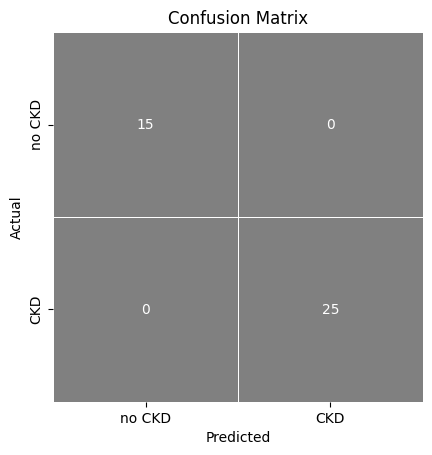

In [11]:
grid_search = GridSearchCV(
    RandomForestClassifier(), 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
).fit(X_train, y_train)
predicted = grid_search.predict(X_test)

sns.heatmap(
    metrics.confusion_matrix(y_test, predicted), 
    annot=True, 
    fmt="d", 
    cbar = False,
    cmap=ListedColormap(['grey']),
    linewidths=0.5,
    square=True,
    xticklabels=["no CKD", "CKD"],
    yticklabels=["no CKD", "CKD"],
)

# Set labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

print(
    metrics.classification_report(
        y_test,
        predicted
    )
)

## Discussion

### Significance of each predictor


### Privacy Considerations
Rubini et al. did not disclose any demographic or identifiable information in the dataset. This project regarded only those provided clinical attributes, making no attempt to identify any individuals. 

# References
1. Rubini, L., Soundarapandian, P., and Eswaran, P. (2015) Chronic_Kidney_Disease. UCI Machine Learning Repository. Available at: https://archive.ics.uci.edu/dataset/336/chronic+kidney+disease [Accessed: 23 June 2023]. DOI: https://doi.org/10.24432/C5G020.

2. Kidney Health Australia (2020). Chronic Kidney Disease (CKD) Management in Primary Care (4th ed.). Melbourne: Kidney Health Australia. Available at: https://kidney.org.au/uploads/resources/CKD-Management-in-Primary-Care_handbook_2020.1.pdf [Accessed 23 June 2023]. p.22.